In [1]:
#adapted from: Nancy Cui, Classification.ipynb

from os.path import abspath, dirname
import pandas as pd
import numpy as np
import obonet
import networkx as nx
from pyensembl import EnsemblRelease

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

INFO:matplotlib.font_manager:generated new fontManager


In [2]:
beta_value = pd.read_csv('./../data/all_betavalues_2.txt', sep='\t')
metadata=pd.read_csv('./../data/GEO_metadata_test2.txt',sep='\t')
tissue_ontology_tree=obonet.read_obo('./../annotation/bto.obo')

In [3]:
#remove X and Y chromosomes
beta_value_all=beta_value 
index_names1=beta_value[beta_value['V1']=='chrX'].index
index_names2=beta_value[beta_value['V1']=='chrY'].index
index_names=index_names1.append(index_names2)
beta_value.drop(index_names, inplace=True)
beta_value.reset_index(drop=True)

#label features as: [chr# position]
empty=[' ']*len(beta_value)
feature=np.char.array(beta_value['V1'])+np.char.array(empty)
feature=np.char.array(feature)+np.char.array(list(map(str, beta_value['V2'])))

In [4]:
#Get samples with both methylation data and metadata annotation
beta_samples=list(beta_value.columns)[2:]
metadata_samples=metadata['sample_id']
both_beta_metadata=set(beta_samples).intersection(metadata_samples)
disease_term=metadata['disease_name']
tissue_term=metadata['tissue_name']

#Remove overlapping samples
index_to_delete=['GSM3813550', 'GSM3813542', 'GSM3813555', 'GSM3813541', 'GSM3813540']
for i in index_to_delete:
    both_beta_metadata.remove(i)

In [5]:
normal_sample_index=[i for i in range(0,len(disease_term)) \
                     if ((disease_term[i]=='normal') and \
                         (tissue_term[i]!='embryonic stem cell line' and \
                          tissue_term[i]!='MDA-MB-436 cell' and \
                          tissue_term[i]!='NCI-H1299 cell'))]
normal_sample_value=tissue_term[normal_sample_index]

In [6]:
#dictionary of names to id from brenda
id_to_name = {id_:data.get('name') for id_, data in tissue_ontology_tree.nodes(data=True)}
name_to_id = {data.get('name'):id_ for id_, data in tissue_ontology_tree.nodes(data=True)}

In [7]:
# Get the correponding nodes of all metadata (selected_nodes) 
# and all the nodes that connect them into a DAG (completed nodes)
def create_subgraph(tissue_ontology_tree,normal_sample_value):
    selected_nodes=list(name_to_id[x] for x in list(set(normal_sample_value)))
    completed_nodes=[]
    for node_element in selected_nodes:
        print(node_element)
        completed_nodes=completed_nodes+list(nx.ancestors(tissue_ontology_tree,node_element))
    completed_nodes=completed_nodes+selected_nodes
    return(completed_nodes)

completed_nodes=create_subgraph(tissue_ontology_tree,normal_sample_value)

BTO:0001025
BTO:0003833
BTO:0001253
BTO:0004053
BTO:0000047
BTO:0003435
BTO:0001379
BTO:0000988
BTO:0000155
BTO:0001613
BTO:0005871
BTO:0000553
BTO:0000759
BTO:0001255
BTO:0000089
BTO:0001563
BTO:0000269
BTO:0001202
BTO:0000876


In [8]:
# Create subgraph containing all completed nodes (DAG)
tissue_subgraph=tissue_ontology_tree.subgraph(completed_nodes)
# display(nx.draw(tissue_subgraph,pos=nx.circular_layout(tissue_subgraph, scale=5),with_labels=True,font_size=8))
# print(list(name_to_id[i] for i in list(tissue_subgraph.nodes())))
# print(nx.is_weakly_connected(tissue_subgraph))
# print(len(completed_nodes))
# print(len(tissue_subgraph.nodes))

In [9]:
# Create binary classifier Y values 
def get_indicator_matrix(node):
    id_node=name_to_id[node]
#     print(id_node)
    ancestor_nodes=[i for i in normal_sample_index \
                    if name_to_id[tissue_term[i]] in nx.ancestors(tissue_ontology_tree, id_node)]
#     print(ancestor_nodes)
    positive_sample_index=[i for i in normal_sample_index \
                           if name_to_id[tissue_term[i]] \
                           not in nx.descendants(tissue_ontology_tree, id_node) \
                           and \
                           (name_to_id[tissue_term[i]] in nx.ancestors(tissue_ontology_tree, id_node) \
                            or name_to_id[tissue_term[i]]==id_node)]
    y_matrix=np.zeros(((len(tissue_term)), 1))
    y_matrix[positive_sample_index]=1
    samples_keep=list(set(normal_sample_index)-set(ancestor_nodes))
    y_matrix_sample=y_matrix[samples_keep]
#     print(len(y_matrix))
#     print(len(y_matrix_sample))
    return(y_matrix_sample,ancestor_nodes,positive_sample_index)

[x,y,z]=get_indicator_matrix('adrenal gland')
[x,y,z]=get_indicator_matrix('memory T-lymphocyte')

In [12]:
#GRCh38
#gene at locus, exon ids, etc 
data = EnsemblRelease(77)

peripheral blood mononuclear cell
Accuracy: 0.9918032786885246


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.9974872937011022


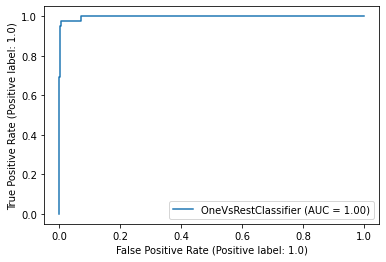

          peripheral blood mononuclear cell
auc                                0.997487
accuracy                           0.991803

buccal mucosa
Accuracy: 0.9774590163934426


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.8407949790794979


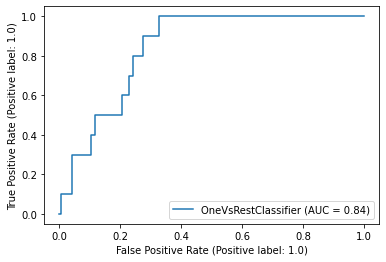

          peripheral blood mononuclear cell  buccal mucosa
auc                                0.997487       0.840795
accuracy                           0.991803       0.977459

skin
Accuracy: 1.0


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:1.0


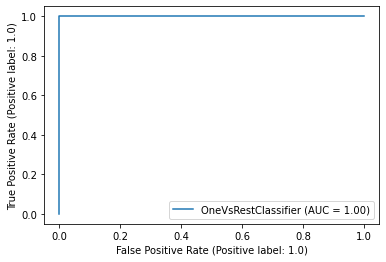

          peripheral blood mononuclear cell  buccal mucosa  skin
auc                                0.997487       0.840795   1.0
accuracy                           0.991803       0.977459   1.0

umbilical cord blood
Accuracy: 0.9959016393442623


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.9998136645962733


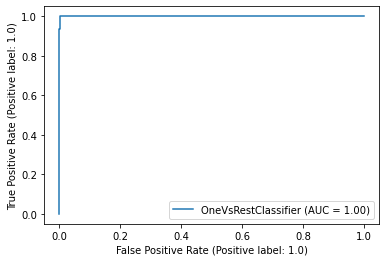

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  
auc                   0.999814  
accuracy              0.995902  

adrenal gland
Accuracy: 1.0


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:1.0


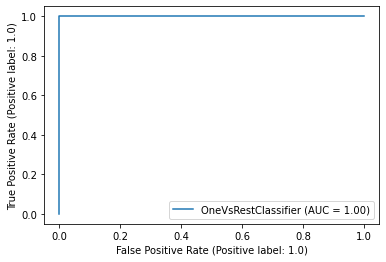

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  
auc                   0.999814            1.0  
accuracy              0.995902            1.0  

memory T-lymphocyte
Accuracy: 0.9979508196721312


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:1.0


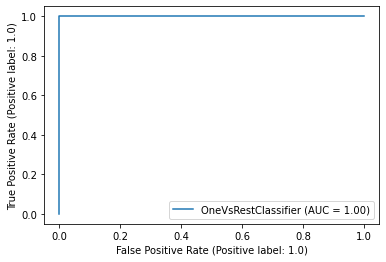

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  
auc                   0.999814            1.0             1.000000  
accuracy              0.995902            1.0             0.997951  

thyroid gland
Accuracy: 1.0


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:1.0


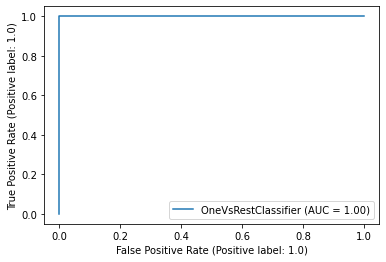

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  
auc                 1.0  
accuracy            1.0  

pancreas
Accuracy: 0.9959016393442623


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.9609053497942387


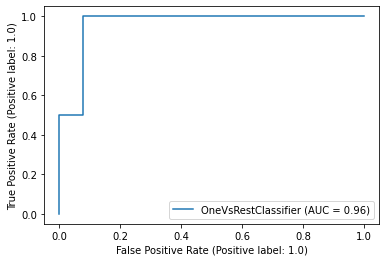

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  
auc                 1.0  0.960905  
accuracy            1.0  0.995902  

bronchoalveolar lavage fluid
Accuracy: 0.9877049180327869


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.824634655532359


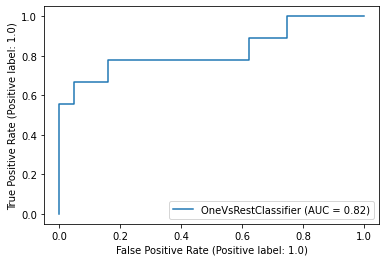

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  
auc                 1.0  0.960905                      0.824635  
accuracy            1.0  0.995902                      0.987705  

colorectum
Accuracy: 1.0


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:1.0


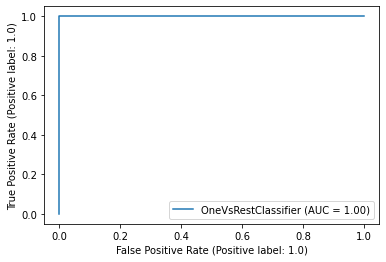

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  
auc                 1.0  0.960905                      0.824635         1.0  
accuracy            1.0  0.995902                      0.987705         1.0  

naive T-lymphocyte
Accuracy: 0.9938524590163934


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.9897330595482546


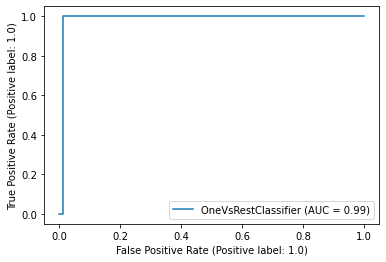

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  
auc                 0.989733  
accuracy            0.993852  

peripheral blood
Accuracy: 0.9977728285077951


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:1.0


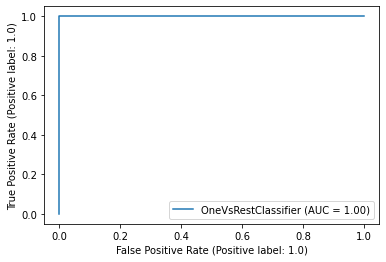

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  peripheral blood  
auc                 0.989733          1.000000  
accuracy            0.993852          0.997773  

liver
Accuracy: 1.0


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:1.0


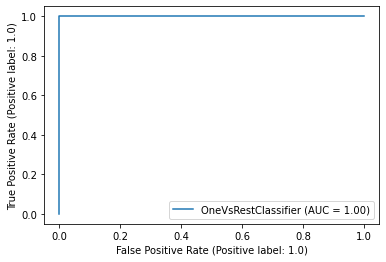

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  peripheral blood  liver  
auc                 0.989733          1.000000    1.0  
accuracy            0.993852          0.997773    1.0  

skin fibroblast
Accuracy: 0.9959016393442623


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.973305954825462


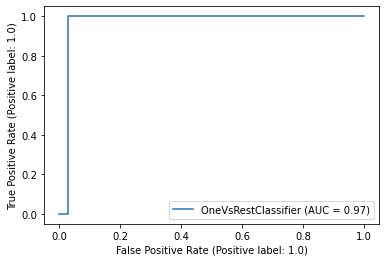

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  peripheral blood  liver  skin fibroblast  
auc                 0.989733          1.000000    1.0         0.973306  
accuracy            0.993852          0.997773    1.0         0.995902  

blood
Accuracy: 0.9003322259136213


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.9077286135693214


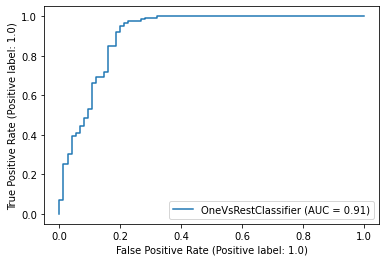

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  peripheral blood  liver  skin fibroblast  \
auc                 0.989733          1.000000    1.0         0.973306   
accuracy            0.993852          0.997773    1.0         0.995902   

             blood  
auc       0.907729  
accuracy  0.900332  

vastus lateralis
Accuracy: 0.9795081967213115


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.995365466101695


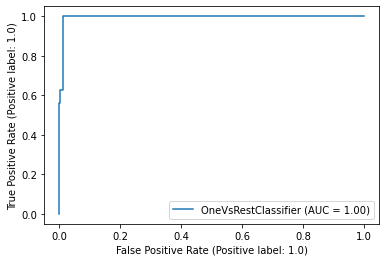

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  peripheral blood  liver  skin fibroblast  \
auc                 0.989733          1.000000    1.0         0.973306   
accuracy            0.993852          0.997773    1.0         0.995902   

             blood  vastus lateralis  
auc       0.907729          0.995365  
accuracy  0.900332          0.979508  

colon

/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.8497942386831276


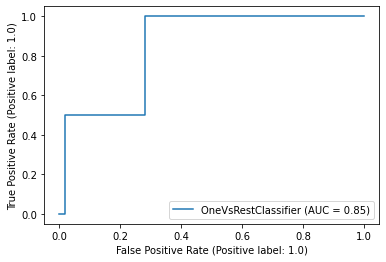

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  peripheral blood  liver  skin fibroblast  \
auc                 0.989733          1.000000    1.0         0.973306   
accuracy            0.993852          0.997773    1.0         0.995902   

             blood  vastus lateralis     colon  
auc       0.907729          0.995365  0.849794  
accuracy  0.900332       

/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.995940170940171


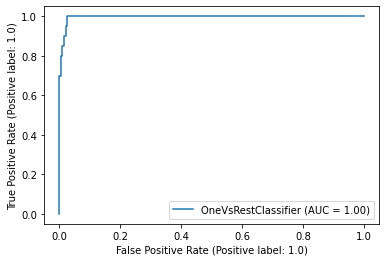

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  peripheral blood  liver  skin fibroblast  \
auc                 0.989733          1.000000    1.0         0.973306   
accuracy            0.993852          0.997773    1.0         0.995902   

             blood  vastus lateralis     colon    saliva  
auc       0.907729          0.995365  0.849794  0.995940  
accur

/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.9917864476386037


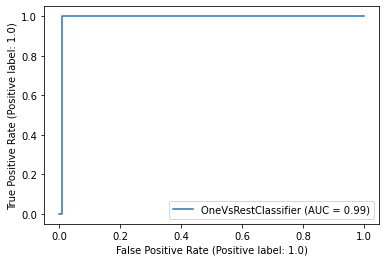

          peripheral blood mononuclear cell  buccal mucosa  skin  \
auc                                0.997487       0.840795   1.0   
accuracy                           0.991803       0.977459   1.0   

          umbilical cord blood  adrenal gland  memory T-lymphocyte  \
auc                   0.999814            1.0             1.000000   
accuracy              0.995902            1.0             0.997951   

          thyroid gland  pancreas  bronchoalveolar lavage fluid  colorectum  \
auc                 1.0  0.960905                      0.824635         1.0   
accuracy            1.0  0.995902                      0.987705         1.0   

          naive T-lymphocyte  peripheral blood  liver  skin fibroblast  \
auc                 0.989733          1.000000    1.0         0.973306   
accuracy            0.993852          0.997773    1.0         0.995902   

             blood  vastus lateralis     colon    saliva  monocyte  
auc       0.907729          0.995365  0.849794  0.9959

In [15]:
all_genes=dict()
results=pd.DataFrame()

for i in set(normal_sample_value):
    print(i)
    [y_matrix_single, ancestor_nodes, positive_sample]=get_indicator_matrix(i)
#     print(y_matrix_single.shape)
    
    #beta values of relevant nodes (normal samples without ancestor nodes)
    x_matrix_single=beta_value.iloc[:,list(set(normal_sample_index)-set(ancestor_nodes))]
    value_X=np.transpose(np.array(x_matrix_single))
#     print(value_X.shape)

    #filter by variance and get mask
    selector=VarianceThreshold(threshold=(0.09))
    filtered_X=selector.fit_transform(value_X)
    mask=selector.get_support(indices=True)
#     print(mask)

    #filtered [chr# position] with mask
    filtered_feature=list(feature[mask])
#     print(filtered_feature)
    
    #split train/test
    X_train,X_test,y_train,y_test=train_test_split(filtered_X, y_matrix_single, 
                                                   stratify= y_matrix_single,
                                                   test_size=0.20, random_state=42)
    
    #one vs rest linear svm accuracy
    clf = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, y_train)
    print("Accuracy:",clf.score(X_test, y_test))
    
    #decision function coeff
    coefficients=list(clf.coef_[0,:])
    coeffdict={coefficients[i]:filtered_feature[i] for i in range(0, len(coefficients))}
    coordinate_coeffdict={coefficients[i]:mask[i] for i in range(0, len(coefficients))}
    sorted_coeffs=sorted(coefficients, key=abs, reverse=True)
    CpGcoord20=[coordinate_coeffdict[key] for key in sorted_coeffs[0:20]]
    gene_names=[]
    gene_ids=[]
    for j in CpGcoord20:
        chromo=beta_value['V1'][j].split('chr')[1]
        CpGposition=beta_value['V2'][j]
        gene_names.append(data.gene_names_at_locus(contig=chromo, position=int(CpGposition)))
        gene_ids.append(data.gene_ids_at_locus(contig=chromo, position=int(CpGposition)))
        
    all_genes.update({i:gene_names})
#     print(gene_names)
#     print(gene_ids)

    #print 20 top decision function coeffs
#     fig = plt.figure()
#     ax = fig.add_axes([0,0,1,1])
#     ax.bar([coeffdict[key] for key in sorted_coeffs[0:20]],sorted_coeffs[0:20])
#     plt.xticks(rotation=90)
#     plt.show()
#     y_prob=clf.predict_proba(X_test)
    y_score = clf.fit(X_train, y_train).decision_function(X_test)

    #auc
    fpr, tpr, _ = roc_curve(y_test, y_score)
    print('AUC:'+str(auc(fpr,tpr)))
    plot_roc_curve(clf, X_test, y_test)
    plt.show()
    
    results.loc['auc', i]=auc(fpr, tpr)
    results.loc['accuracy', i]=clf.score(X_test, y_test)
    print(results)
    
    print()
    

In [17]:
results

,peripheral blood mononuclear cell,buccal mucosa,skin,umbilical cord blood,adrenal gland,memory T-lymphocyte,thyroid gland,pancreas,bronchoalveolar lavage fluid,colorectum,naive T-lymphocyte,peripheral blood,liver,skin fibroblast,blood,vastus lateralis,colon,saliva,monocyte
auc,0.997487,0.840795,1.0,0.999814,1.0,1.000000,1.0,0.960905,0.824635,1.0,0.989733,1.000000,1.0,0.973306,0.907729,0.995365,0.849794,0.995940,0.991786
accuracy,0.991803,0.977459,1.0,0.995902,1.0,0.997951,1.0,0.995902,0.987705,1.0,0.993852,0.997773,1.0,0.995902,0.900332,0.979508,0.995902,0.985656,0.997951


(array([[ 85197.,  14446.,   9166., ...,  39694.,  85051., 150714.],
        [ 88594.,  12137.,   8382., ...,  41250.,  82018., 152599.],
        [ 90091.,  11530.,   8485., ...,  39263.,  79295., 157258.],
        ...,
        [128849.,  22368.,  13663., ...,  24608.,  45668., 149028.],
        [128146.,  22679.,  13689., ...,  24371.,  45104., 150252.],
        [128486.,  22485.,  13680., ...,  23200.,  43251., 155997.]]),
 array([5.73656604e-06, 1.00005163e-01, 2.00004589e-01, 3.00004015e-01,
        4.00003442e-01, 5.00002868e-01, 6.00002294e-01, 7.00001721e-01,
        8.00001147e-01, 9.00000573e-01, 9.99999999e-01]),
 <a list of 4182 BarContainer objects>)

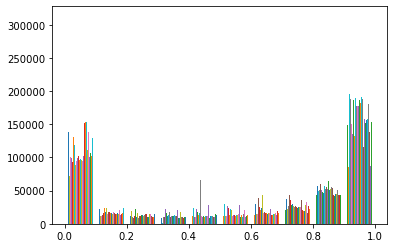

In [16]:
plt.hist(beta_value.iloc[:,2:])

In [ ]:
beta_value.iloc[:,2:].hist()

array([[<AxesSubplot:title={'center':'GSM2722207'}>,
        <AxesSubplot:title={'center':'GSM2722208'}>,
        <AxesSubplot:title={'center':'GSM2722209'}>, ...,
        <AxesSubplot:title={'center':'GSM3383561'}>,
        <AxesSubplot:title={'center':'GSM3383562'}>,
        <AxesSubplot:title={'center':'GSM3383563'}>],
       [<AxesSubplot:title={'center':'GSM3383564'}>,
        <AxesSubplot:title={'center':'GSM3383565'}>,
        <AxesSubplot:title={'center':'GSM3383566'}>, ...,
        <AxesSubplot:title={'center':'GSM3427607'}>,
        <AxesSubplot:title={'center':'GSM3427608'}>,
        <AxesSubplot:title={'center':'GSM3427609'}>],
       [<AxesSubplot:title={'center':'GSM3427610'}>,
        <AxesSubplot:title={'center':'GSM3427611'}>,
        <AxesSubplot:title={'center':'GSM3427612'}>, ...,
        <AxesSubplot:title={'center':'GSM3665321'}>,
        <AxesSubplot:title={'center':'GSM3665322'}>,
        <AxesSubplot:title={'center':'GSM3665323'}>],
       ...,
       [<AxesSub